# Calculate Metrics and Generate New Sequences

In [1]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns

import scipy 
import editdistance
import sklearn.metrics
import statsmodels.api as sm

%matplotlib inline 
np.random.seed(17)

## Pre-Process Multiple Sequences

In [2]:
## Function to pre-process input CSV of original song into form that can be used for modeling and metrics
## Assumes original piece's MIDI file has been converted to a CSV using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5
## input_filename = name of original csv
## output_filename = name of new csv to save generated piece to
## Outputs:
##         quarter_note = number of time steps corresponding to 1 quarter note
##         num = numerator in key signature
##         denom = denominator in key signature
##         key = key signature of piece, integer between -7 and 7 where 0 is C Major
##         measures = number of measures in input piece
##         time = vector of time stamps at which notes occurr
##         notes = vector of note pitches (integers 0-127)
##         velocity = "volume" of each note pitch, 0 = note off, length of time is the same as length of notes and velocity
##         song = pandas dataframe to use for output generated pieces, retains formatting expected by MIDI-CSV
##         song.index = index of original song dataframe

## See http://www.fourmilab.ch/webtools/midicsv/#midicsv.5 for a discussion of MIDI and CSV formats

class pre_process(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
     
   
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = song.iloc[r, 3].values.astype(int)[0]
        denom = song.iloc[r, 4].values.astype(int)[0]**2
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
       
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int)
        time2 = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, time2, notes, velocity, song, song_model.index)

In [240]:
## Convert midi note pitches to note names
# Print with sharps or flats?
def midi_to_notenames(notes, sharp = True):
    if sharp:
        note_list = ['']*21 + ['A0','A#0', 'B0'] 
        note_list = note_list + [s + '1' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '2' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '3' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '4' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '5' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '6' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '7' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']]
    else:
        note_list = ['']*21 + ['A0','Bb0', 'B0'] 
        note_list = note_list + [s + '1' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '2' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '3' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '4' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '5' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '6' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '7' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
    return(np.array(note_list)[np.unique(notes)])

In [3]:
## Helper functions for working with note pitch representation

## Convert from pitch representation (integers 0-127) to integers (0-max)
## x is the input vector of notes and code is a vector of the unique pitches in x
def encode(x, code):
    output = np.array([int(np.where(code == x[i])[0]) for i in range(0, len(x))])
    return output


## Reverses the function encode
## x is the vector of pitches to decode and code is a vector of the unique pitches in x before it was encoded
def decode(x, code):
    output = np.zeros(len(x))
    for i in range(0, len(x)):
        output[i] = code[x[i]]
    return output

## Function to convert the values in array to the nearest values in the array value
## Used to convert continues TVAR generated pitches to closest integer values for MIDI representation
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Key = 0 is C major, transpose all pieces to C major
# Key ranges from -7 (each flat below C) to + 7 (each sharp above C)

def transpose(key, notes):
    notes_transpose = -key + notes # get key to 0
    return(notes_transpose)

In [4]:
def multiple_process(file_list, min_note_list):
    ## Read in each piece and store information
    quarter_list = list()
    key_list = list()
    time_list = list()
    time_metrics = list()
    note_list = list()
    transposed = list()
    velocity_list = list()
    encoded_notes = list()
    song_list = list()
    ind_list = list()
    num_list = list()
    measure_list = list()

    
#     calc_metrics(time_metrics, notes, notes, velocity, measures, min_note, num)

    for i in range(len(file_list)):
        quarter_note, num, denom, key, measures, time, time2,\
                notes, velocity, song, ind = pre_process(file_list[i], min_note_list[i]).read_process()
        quarter_list.append(quarter_note)
        key_list.append(key)
        time_list.append(time)
        time_metrics.append(time2)
        note_list.append(notes)
        # Transpose
        tNotes = transpose(key, notes)
        transposed.append(tNotes)
        velocity_list.append(velocity)
        print(file_list[i])
        song_list.append(song)
        ind_list.append(ind)
        num_list.append(num)
        measure_list.append(measures)
    
    
    
    
    ## All sequences need to be encoded to same reference
    possibleNotes = np.unique(np.concatenate([np.unique(transposed[i]) for i in range(len(file_list))]).ravel())
    encoded_notes = [encode(transposed[i], possibleNotes) for i in range(len(file_list))]
    
    
    T = np.max([len(n) for n in transposed])
    N = len([len(n) for n in transposed])
    ## ragged array of encoded pieces
    mat_pieces = np.zeros((N, T), dtype = int)

    for i in range(N):
        curr = encoded_notes[i]
        mat_pieces[i, :len(curr)] = curr
        
    
        
    return(mat_pieces, quarter_list, key_list, time_list, note_list, transposed, velocity_list, encoded_notes,
          possibleNotes, time_metrics, song_list, ind_list, num_list, measure_list)


In [5]:
file_list = ['OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv',
             'OriginalCSV/carol-of-the-bells.csv',
             'OriginalCSV/deutschlandlied.csv',
             'OriginalCSV/god-rest-you-merry-gentlemen.csv',
             'OriginalCSV/greensleeves.csv',
             'OriginalCSV/hark-the-herald-angels-sing.csv',
             'OriginalCSV/Jupiter.csv', 
             'OriginalCSV/in-the-bleak-midwinter.csv', 
             'OriginalCSV/muss_1_format0.csv', 
             'OriginalCSV/old-100th.csv', 
             'OriginalCSV/once-in-royal.csv', 
             'OriginalCSV/pachelbel.csv', 
             'OriginalCSV/shall-we-gather-at-the-river.csv', 
             'OriginalCSV/Songwithoutwords06.csv', 
             'OriginalCSV/swing-low-sweet-chariot.csv', 
             'OriginalCSV/the-blue-danube-piano.csv', 
             'OriginalCSV/Third-Mode-Melody.csv', 
             'OriginalCSV/twinkle-twinkle-little-star.csv',
             'OriginalCSV/we-three-kings-keyboard.csv',
             'OriginalCSV/when-johnny-comes-marching-home.csv']
min_note_list = [128, 128, 128, 128, 64, 128, 64, 128, 240, 256, 128, 64, 64, 64, 128, 256, 256, 256, 64, 128]

In [6]:
len(min_note_list)

20

In [9]:
mat_pieces, quarter_list, key_list, time_list, note_list, transposed, velocity_list, encoded_notes, \
          possibleNotes, time_metrics, song_list, ind_list, num_list, measure_list = multiple_process(file_list, min_note_list)

OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv
OriginalCSV/carol-of-the-bells.csv
OriginalCSV/deutschlandlied.csv
OriginalCSV/god-rest-you-merry-gentlemen.csv
OriginalCSV/greensleeves.csv
OriginalCSV/hark-the-herald-angels-sing.csv
OriginalCSV/Jupiter.csv
OriginalCSV/in-the-bleak-midwinter.csv
OriginalCSV/muss_1_format0.csv
OriginalCSV/old-100th.csv
OriginalCSV/once-in-royal.csv
OriginalCSV/pachelbel.csv
OriginalCSV/shall-we-gather-at-the-river.csv
OriginalCSV/Songwithoutwords06.csv
OriginalCSV/swing-low-sweet-chariot.csv
OriginalCSV/the-blue-danube-piano.csv
OriginalCSV/Third-Mode-Melody.csv
OriginalCSV/twinkle-twinkle-little-star.csv
OriginalCSV/we-three-kings-keyboard.csv
OriginalCSV/when-johnny-comes-marching-home.csv


In [10]:
possibleNotes

array([31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 86])

In [11]:
mat_pieces.shape

(20, 1380)

In [14]:
np.array([len(i) for i in transposed])

array([ 532, 1220,  940,  740,  432, 1068, 1168,  702, 1343,  524,  580,
       1050, 1112,  582, 1380,  496,  242,  178,  620,  686])

# Learning Algorithms - Handle Label Switching

Order hidden states so hidden state 0 is the most likely hidden state and hidden state m is the least likely

## First Order HMM

In [210]:
def logSumExp(a):
    if np.all(np.isinf(a)):
        return np.log(0)
    elif len(a)==0:
        return (np.log(0))
    else:
        b = np.max(a)
    return(b + np.log(np.sum(np.exp(a-b))))

def forwardHMM(n, m, pi, A, b, x):
    alpha = np.zeros((n,m))
    for i in range(0,m):
        alpha[0,i] =pi[i] +b[i, x[0]]
    
    for i in range(1, n):
        for j in range(0, m):
            alpha[i,j] = logSumExp(np.asarray(alpha[i-1, :])+np.asarray(A[:,j])+b[j,x[i]])
    return(alpha)
def backwardHMM(n, m, pi, A, b, x):
    beta = np.zeros((n,m))
#log1=0 so no initialization
    for t in range(n-2, -1, -1):
        for i in range(0, m):
            beta[t,i] = logSumExp(np.asarray(beta[t+1,: ]) + np.asarray(A[i,:]) + b[:, x[t+1]])
    return(beta)
    

In [211]:
## Run one iteration of Baum-Welch for one sequence
## n is the length of the sequence
## m is the number of hidden states
## k is the number of possible observed states
## x is a single sequence of observed states
## pi is the current initial distribution (on the log scale)
## A is the current transition matrix (on the log scale)
## b is the current emission distribution (on the log scale)

def optimize(n, m, k, x, pi, b, A):
    gamma = np.zeros((n,m))
    xi = np.zeros((n,m,m))
    
    #Perform forward and backward algorithms# 
    alpha=forwardHMM(n,m,pi,A,b,x)
    beta=backwardHMM(n,m,pi,A,b,x)
    pNew = logSumExp(alpha[len(x)-1,:])
    
    #Calculate gamma and xi#
    for t in range(0, n):
        for i in range(0,m):
            gamma[t,i] = alpha[t,i] + beta[t,i] - pNew

    for t in range(1, n):
        for i in range(0, m):
            for j in range(0, m):
                xi[t,i,j] = A[i,j] + b[j, x[t]] + alpha[t-1, i] + beta[t, j] - pNew

    ## Update parameters via Baum-Welch
    pi = gamma[0,:] - logSumExp(gamma[0,:])
    for i in range(0, m):
        for j in range(0, m):
            A[i,j] = logSumExp(xi[1::, i, j]) - logSumExp(xi[1::, i,:])
   
    for i in range(0,m):
        for w in range(0, k):
            j = 0
            count = 0
            for t in range(0,n):
                if x[t] == w:
                    count = count+1
            indicies = np.zeros(count)
            for t in range(0,n):
                if x[t] == w:
                    indicies[j] = gamma[t,i]
                    j = j+1
                    
            if len(indicies) == 0: ## Smoothing
                b[i,w] = np.log(0.000001)
            else:
                b[i,w] = logSumExp(indicies) - logSumExp(gamma[:,i])
                
       
    ## Handle label switching
    ## Hidden state with highest probability has lowest log probability
    ind_order = np.flip(np.argsort(np.sum(A, axis = 0)))
    ## now, hidden state 0 has the highest probability
    A = A[np.ix_(ind_order, ind_order)]
    ## Re-order emission distribution
    b = b[ind_order,:]
        
        
    return (pNew, pi, b, A)

In [236]:
### Learn parameters for first order HMM trained on multiple sequences
## N is the number of training pieces
## Tlist is list of length of each piece
## m is the number of hidden states
## k is the number of possible emission notes
## X an N x max(Tlist) matrix with the encoded notes of each piece
## tol is the tolerance to use for convergence of the EM algorithm
def HMM_mult(N, Tlist, m, k, X, tol):
    #randomly initialize A, b and pi as arrays of correct dimension, first index is over N
    pi = np.random.rand(N, m)
    pi = np.log(pi/np.sum(pi, axis = 1)[:, None])
    
    A = np.random.rand(N,m,m)
    A = np.log(A/np.sum(A, axis=2)[:,:, None])
    
    b = np.random.rand(N, m, k)
    b = np.log(b/np.sum(b, axis=2)[:,:, None])

    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pCompare = 0
    pNew = np.zeros(N)
    
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
        for i in range(N):
            ## Baum Welch for individual sequences
            pNew[i], pi[i, :], b[i,:,:], A[i,:,:] =  optimize(Tlist[i], m, k, X[i,:Tlist[i]], 
                                                              pi[i,:], b[i,:,:], A[i,:,:])
        
        ## States ordered by most likely sequence of hidden states, so can do a direct weighted average
        pNew = pNew/np.sum(pNew)
        A = A * pNew[:, np.newaxis, np.newaxis]
        Anew = np.sum(A, axis = 0)
        ## Renormalize
        Anew = np.log(np.exp(Anew)/np.sum(np.exp(Anew), axis=1)[:, None])
        ## Same A matrix for all pieces
        A = np.repeat(Anew[np.newaxis, :, :], N, axis=0)
        
        pi = pi*pNew[:, np.newaxis]
        piNew = np.sum(pi, axis = 0)
        ## Renormalize
        piNew = np.log(piNew/np.sum(piNew))
        ## Same pi vector for all pieces
        pi = np.repeat(piNew[np.newaxis, :], N, axis=0)
        
        b = b * pNew[:, np.newaxis, np.newaxis]
        bnew = np.sum(b, axis = 0)
        ## Renormalize
        bnew = np.log(np.exp(bnew)/np.sum(np.exp(bnew), axis=1)[:, None])
        ## Same A matrix for all pieces
        b = np.repeat(bnew[np.newaxis, :, :], N, axis=0)
        
        
        pCompare = np.max(pNew)
        criteria = abs(pOld-pCompare)
        if criteria < tol:
            convergence = 1
        elif iterations > 300:
            convergence = 1
        else:
            convergence = 0
            pOld = pCompare
            iterations +=1
            if iterations % 10 == 0:
                print(iterations)
    return (iterations, pNew, np.exp(piNew), np.exp(bnew), np.exp(Anew))
    

In [237]:
## Run Training
N = len(file_list)
Tlist =  np.array([len(i) for i in transposed])
m = 5
k = len(possibleNotes)
X = mat_pieces
tol = 0.001
_, _, pi, b, A = HMM_mult(N, Tlist, m, k, X, tol)

In [242]:
np.save("Label-Switch-Parameters/HMM-5-pi.npy", pi)
np.save("Label-Switch-Parameters/HMM-5-b.npy", b)
np.save("Label-Switch-Parameters/HMM-5-A.npy", A)

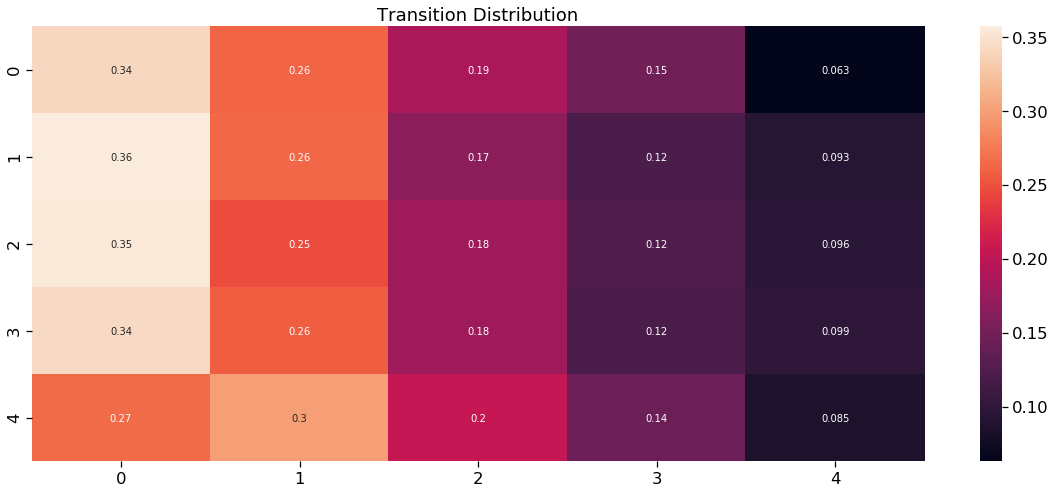

In [243]:
plt.figure(figsize = (20,8))
plt.title('Transition Distribution')
dil1 = pd.DataFrame(np.round(A, 3))
axs = sns.heatmap(dil1, annot=True)

States with the highest probability (0) have high transition probabilities

In [244]:
## Run Training
N = len(file_list)
Tlist =  np.array([len(i) for i in transposed])
m = 10
k = len(possibleNotes)
X = mat_pieces
tol = 0.001
_, _, pi10, b10, A10 = HMM_mult(N, Tlist, m, k, X, tol)

In [245]:
pi10

array([0.09792508, 0.09950448, 0.09879915, 0.09925343, 0.09902339,
       0.10105258, 0.10106206, 0.10139862, 0.10136899, 0.10061222])

In [246]:
np.save("Label-Switch-Parameters/HMM-10-pi.npy", pi10)
np.save("Label-Switch-Parameters/HMM-10-b.npy", b10)
np.save("Label-Switch-Parameters/HMM-10-A.npy", A10)

## Dilated Convolutions - 1 Layer

In [267]:
def forwardDC(n, m, pi, A, b,b0, x):
    alpha = np.zeros((n,m))
    for i in range(0,m):
        alpha[0,i] =pi[i] +b0[ i, x[0]]
    
    for i in range(1, n):
        for j in range(0, m):
            alpha[i,j] = logSumExp(np.asarray(alpha[i-1, :])+np.asarray(A[:,j])+b[:,j,x[i]])
    return(alpha)

def backwardDC(n, m, pi, A, b, x):
    beta = np.zeros((n,m))
    
    for t in range(n-2, -1, -1):
        for i in range(0, m):
            beta[t,i] = logSumExp(np.asarray(beta[t+1,: ]) + np.asarray(A[i,:]) + b[i,:, x[t+1]])
    return(beta)

In [268]:
## Run one iteration of Baum-Welch for one sequence
## n is the length of the sequence
## m is the number of hidden states
## k is the number of possible observed states
## x is a single sequence of observed states
## pi is the current initial distribution (on the log scale)
## b0 is the current initial emission distribution (on the log scale)
## A is the current transition matrix (on the log scale)
## b is the current emission distribution (on the log scale)

def optimizeDC(n, m, k, x, pi, b0, b, A):
    gamma = np.zeros((n,m))
    xi = np.zeros((n,m,m))
    
    #Perform forward and backward algorithms# 
    alpha = forwardDC(n, m, pi, A, b,b0, x)
    beta = backwardDC(n, m, pi, A, b, x)
    pNew = logSumExp(alpha[len(x)-1,:])
    
    
    
    #Calculate gamma and xi#
    for t in range(0, n):
        for i in range(0,m):
            gamma[t,i] = alpha[t,i] + beta[t,i] - pNew

    for t in range(1, n):
        for i in range(0, m):
            for j in range(0, m):
                xi[t,i,j] = A[i,j] + b[i,j, x[t]] + alpha[t-1, i] + beta[t, j] - pNew

    pi = gamma[0,:] - logSumExp(gamma[0,:])
    for i in range(0, m):
        for j in range(0, m):
            A[i,j] = logSumExp(xi[1::, i, j]) - logSumExp(xi[1::, i,:])
    
    ## Update parameters via Baum-Welch
    for i in range(0,m):
        for j in range(0,m):
            for w in range(0, k):
                h = 0
                count = 0
                for t in range(1,n):
                    if x[t] == w:
                        count = count+1
                indicies = np.zeros(count)
                for t in range(1,n):
                    if x[t] == w:
                        indicies[h] = xi[t,i,j]
                        h = h+1
                if len(indicies) == 0: ## Smoothing
                    b[i,j,w] = np.log(0.000001)
                else:
                    b[i,j,w] = logSumExp(indicies) - logSumExp(xi[1::,i,j])
    
    ## Handle label switching
    ## Hidden state with highest probability has lowest log probability
    ind_order = np.flip(np.argsort(np.sum(A, axis = 0)))
    ## now, hidden state 0 has the highest probability
    A = A[np.ix_(ind_order, ind_order)]
    ## Re-order  emission distribution
    b0 = b0[ind_order,:]
    b = b[np.ix_(ind_order, ind_order)]
        
        
    return (pNew, pi, b0, b, A)

In [305]:
### Learn parameters for first order HMM trained on multiple sequences
## N is the number of training pieces
## Tlist is list of length of each piece
## m is the number of hidden states
## k is the number of possible emission notes
## X an N x max(Tlist) matrix with the encoded notes of each piece
## tol is the tolerance to use for convergence of the EM algorithm
def DC_mult(N, Tlist, m, k, X, tol):
    #randomly initialize A, b and pi as arrays of correct dimension, first index is over N
    pi = np.random.rand(N, m)
    pi = np.log(pi/np.sum(pi, axis = 1)[:, None])
    
    A = np.random.rand(N,m,m)
    A = np.log(A/np.sum(A, axis=2)[:,:, None])
    
    b = np.random.rand(N, m, m, k)
    b = np.log(b/np.sum(b, axis=3)[:, :, :, None])
   
    b0 = 0.000001*np.ones((N, m,k))
    for i in range(N):
        for j in range(m):
            b0[i,j,X[i,0]] = 1
    
    b0 = np.log(b0)

    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pCompare = 0
    pNew = np.zeros(N)
    
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
        for i in range(N):
            ## Baum Welch for individual sequences
            pNew[i], pi[i, :], b0[i,:,:], b[i,:,:], A[i,:,:] =  optimizeDC(Tlist[i], m, k, X[i,:Tlist[i]], 
                                                              pi[i,:], b0[i,:,:], b[i,:,:,:], A[i,:,:])
        
        ## States ordered by most likely sequence of hidden states, so can do a direct weighted average
        pNew = pNew/np.sum(pNew)
        A = A * pNew[:, np.newaxis, np.newaxis]
        Anew = np.sum(A, axis = 0)
        ## Renormalize
        Anew = np.log(np.exp(Anew)/np.sum(np.exp(Anew), axis=1)[:, None])
        ## Same A matrix for all pieces
        A = np.repeat(Anew[np.newaxis, :, :], N, axis=0)
        
        pi = pi*pNew[:, np.newaxis]
        piNew = np.sum(pi, axis = 0)
        ## Renormalize
        piNew = np.log(piNew/np.sum(piNew))
        ## Same pi vector for all pieces
        pi = np.repeat(piNew[np.newaxis, :], N, axis=0)
        
        b0 = b0 * pNew[:, np.newaxis, np.newaxis]
        b0new = np.sum(b0, axis = 0)
        ## Renormalize
        b0new = np.log(np.exp(b0new)/np.sum(np.exp(b0new), axis=1)[:, None])
        ## Same A matrix for all pieces
        b0 = np.repeat(b0new[np.newaxis, :, :], N, axis=0)
        
        b = b * pNew[:, np.newaxis, np.newaxis, np.newaxis]
        bnew = np.sum(b, axis = 0)
        ## Renormalize
        bnew = np.log(bnew/np.sum(bnew, axis=2)[:,:, None])
        ## Same A matrix for all pieces
        b = np.repeat(bnew[np.newaxis, :, :, :], N, axis=0)
        
        
        pCompare = np.max(pNew)
        criteria = abs(pOld-pCompare)
        if criteria < tol:
            convergence = 1
        elif iterations > 300:
            convergence = 1
        else:
            convergence = 0
            pOld = pCompare
            iterations +=1
            if iterations % 10 == 0:
                print(iterations)
    return (iterations, pNew, np.exp(piNew), np.exp(b0new), np.exp(bnew), np.exp(Anew))
    

In [306]:
## Run Training
N = len(file_list)
Tlist =  np.array([len(i) for i in transposed])
m = 5
k = len(possibleNotes)
X = mat_pieces
tol = 0.001
_, _, pi_DC5, b0_DC5, b_DC5, A_DC5 = DC_mult(N, Tlist, m, k, X, tol)

In [307]:
np.save("Label-Switch-Parameters/DC-5-pi.npy", pi_DC5)
np.save("Label-Switch-Parameters/DC-5-b0.npy", b0_DC5)
np.save("Label-Switch-Parameters/DC-5-b.npy", b_DC5)
np.save("Label-Switch-Parameters/DC-5-A.npy", A_DC5)

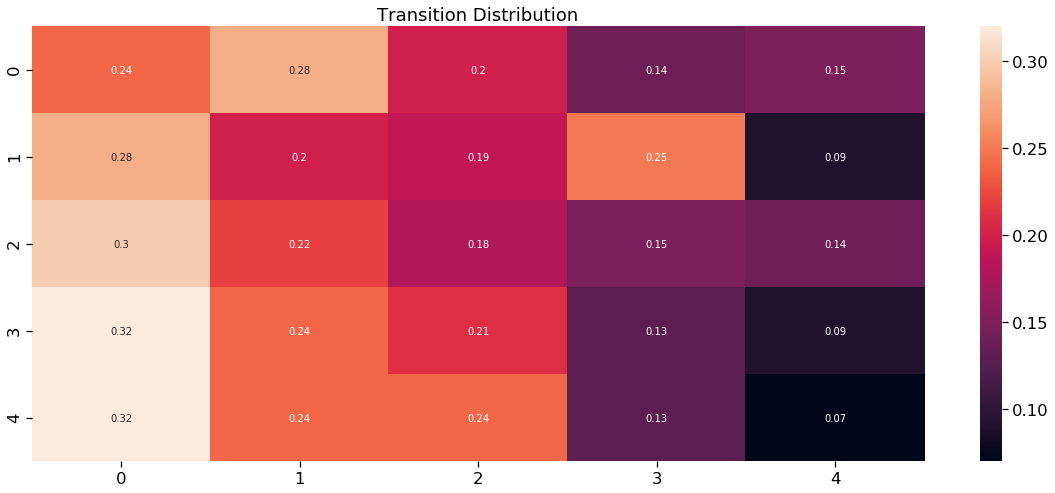

In [308]:
plt.figure(figsize = (20,8))
plt.title('Transition Distribution')
dil1 = pd.DataFrame(np.round(A_DC5, 2))
axs = sns.heatmap(dil1, annot=True)

In [309]:
## Run Training
N = len(file_list)
Tlist =  np.array([len(i) for i in transposed])
m = 10
k = len(possibleNotes)
X = mat_pieces
tol = 0.001
_, _, pi_DC10, b0_DC10, b_DC10, A_DC10 = DC_mult(N, Tlist, m, k, X, tol)

In [310]:
np.save("Label-Switch-Parameters/DC-10-pi.npy", pi_DC10)
np.save("Label-Switch-Parameters/DC-10-b0.npy", b0_DC10)
np.save("Label-Switch-Parameters/DC-10-b.npy", b_DC10)
np.save("Label-Switch-Parameters/DC-10-A.npy", A_DC10)

Now have information about all the original pieces, which can be used in the post-processing when we generate new pieces.

## Generate New Pieces

In [284]:
## n is length of generated sequence
## pi is the initial distribution
## b is the emission distribution
## A is the transition matrix
## generation of first order multiple input
def generate(n,pi,b,A): 
    m = A.shape[0]
    k = b.shape[1]
    ostates=range(0,k)
    xstates=range(0,m)
    o=np.zeros(n,dtype=int)
    x=np.zeros(n,dtype=int)
    x[0]=np.random.choice(xstates,p=pi)
    for j in range(1,n):
        x[j]=np.random.choice(xstates,p=A[x[j-1],:])
    for j in range(0,n):
        o[j]=np.random.choice(ostates,p=b[x[j],:])
    #output=decode(o,code)
    return (o,x)


## T is length of generated sequence
## pi is the initial distribution
## b0 is the initial emission distribution
## b is the emission distribution
## A is the transition matrix
def generate_dilated(n,pi,b0,b,A): 
    m = A.shape[0]
    k = b.shape[2]
    xstates=range(0,k)
    zstates=range(0,m)
    z=np.zeros(n,dtype=int)
    x=np.zeros(n,dtype=int)
    z[0]=np.random.choice(zstates,p=pi)
    x[0]=np.random.choice(xstates,p=b0[z[0],:])
    for j in range(1,n):
        z[j]=np.random.choice(zstates,p=A[z[j-1],:])
    for j in range(1,n):
        x[j]=np.random.choice(xstates,p=b[z[j-1],z[j],:])
#     output=decode(o,code,1)
    return (x,z)

## Metrics Code - One Sequence at a Time

In [283]:

## Function to create a matrix of notes and times representing the input piece as a matrix
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## met_mat output is a matrix where columns correspond to the time stamp of notes, one column for each min_note
##    duration for the entire piece and the rows are the note pitches, values in the matrix are 1 for the duration
##    of a note when it is played and 0 when it is not played
def create_matrix(time, notes, velocity, measures, min_note, num):
    met_mat = pd.DataFrame(np.zeros(shape = (len(np.unique(notes)), int(measures)*num), dtype = int))
    met_mat.index = np.unique(notes)[::-1]
    met_mat.columns = np.arange(0, min_note*num*measures, min_note)[:int(measures)*num]
    max_time = met_mat.columns[-1]
    for i in np.unique(notes):
        on = time[np.intersect1d(np.where(notes == i), np.where(velocity > 0) )]
        off = time[np.intersect1d(np.where(notes == i), np.where(velocity == 0) )]
        if len(off) % 2 !=0 or len(on) %2 !=0:
            off = np.append(off, max_time)
        for j in range(len(on)):
            met_mat.loc[i, on[j]:off[j]] = 1
    return(met_mat)

## Function to calculate the musical metrics of generated pieces
## met_mat is the output from create_matrix()
## harmonic ints is a vector of length 12 corresponding to the counts of each type of harmonic interval in the piece considered
## melodic ints is a vector of length 12 corresponding to the counts of each type of melodic interval in the piece considered
## percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals
def musical_metrics(met_mat):
    perfect = np.array([0,5,7])
    imperfect = np.array([3,4,8,9])
    dissonant = np.array([1,2,6,10,11])
    major_scale = np.array([2,2,1,2,2,2,1])
    harmonic_ints = np.zeros(12)
    c = 0
    max_notes = np.max(np.sum(met_mat, axis = 0))
    melodic = np.zeros(shape = (max_notes, len(met_mat.columns)))
    for col in met_mat.columns:
        chord = np.array(met_mat.index[np.where(met_mat[col] == 1)[0]])[::-1]
        if len(chord) > 0:
            intervals = np.diff(chord)
            intervals[intervals >= 12] = intervals[intervals >= 12] % 12
            harmonic_ints[intervals.astype(int)] +=1
            melodic[:len(chord), c] = chord
            c+= 1
    melodic_ints = list()
    for t in range(melodic.shape[1] - 1):
        m1 = melodic[melodic[:,t] > 0, t]
        m2 = melodic[melodic[:,t+1] > 0, t+1]
        melodic_ints.append(np.unique([abs(i-j) %12 for i in m1 for j in m2]))

    u = np.unique(np.hstack(melodic_ints), return_counts=True)
    m_ints = np.zeros(12)
    m_ints[u[0].astype(int)] = u[1].astype(int)

    h_total = np.sum(harmonic_ints)
    m_total = np.sum(m_ints)

    h_per = np.sum(harmonic_ints[perfect])/h_total
    h_imp = np.sum(harmonic_ints[imperfect])/h_total
    h_dis = np.sum(harmonic_ints[dissonant])/h_total

    m_per = np.sum(m_ints[perfect])/m_total
    m_imp = np.sum(m_ints[imperfect])/m_total
    m_dis = np.sum(m_ints[dissonant])/m_total

    percentage = np.array([h_per, h_imp, h_dis, m_per, m_imp, m_dis])

    return(harmonic_ints, m_ints, percentage)

## Calculate the empirical entropy of the input data and output as a vector in entropy
def ent(data):
    p_data= np.unique(data, return_counts = True)[1]/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy


## Function to compare an original piece to a generated piece and calculate metrics
## old_notes is a vector of the original piece's note pitches
## new_notes is a vector of the generated piece's note pitches
## Returns the empirical entropy, mutual information and edit distance between the original piece and the new, generated piece
##        also returns the count of unique notes in the generated piece, normalized by the total number of notes
def originality_metrics_comparison(old_notes, new_notes):
    # Calculate entropy
    entropy = ent(new_notes)

    # Calculate edit distance
    edit_dist = editdistance.eval(old_notes, new_notes)/len(old_notes)

    # Calculate mutual info
    mutual_info = sklearn.metrics.mutual_info_score(old_notes, new_notes)

    k = len(np.unique(old_notes))
    possibleNotes = np.unique(old_notes)    
    # Calculate note counts
    unique_new_notes, note_counts = np.unique(new_notes, return_counts = True)

    if len(unique_new_notes) != k:
        add_notes = list(set(possibleNotes) - set(unique_new_notes))
        for i in add_notes:
            if np.where(possibleNotes == i)[0] > len(note_counts):
                note_counts = np.append(note_counts, np.where(possibleNotes == i)[0], 0)
            else:
                note_counts = np.insert(note_counts, np.where(possibleNotes == i)[0], 0)
    note_counts = note_counts/len(old_notes)
    return(entropy, mutual_info, edit_dist, note_counts)


## Function to calculate the ACF and PACF out to lag 40
## new_ntoes is the input vector of note pitches
## note_acf is a vector of length 41 of the ACF values and note_pacf is a vector of length 41 of the PACF values
def time_metrics(new_notes):   
    #Calculate ACF/PACF out to lag 40
    note_acf = sm.tsa.stattools.acf(new_notes, fft = False)
    try:
        note_pacf = sm.tsa.stattools.pacf(new_notes)
    except np.linalg.linalg.LinAlgError as err:
        note_pacf = sm.tsa.stattools.pacf(new_notes)

    return(note_acf, note_pacf)


## Function to calculate all metrics
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## output is a vector of the calculated metrics:
##        entropy is the empirical entropy of new_notes
##        mutual_info is the mutual information between old_notes and new_notes
##        edit_dist is the edit distance between old_notes and new_notes
##        harmonic_ints is a vector of length 12 of the count of harmonic intervals of each type in new_notes
##        melodic_ints is a vector of length 12 of the count of melodic intervals of each type in new_notes
##        percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals      
##       note_counts is a vector of length equal to the number of unique pitches in old_notes with a normalized count of pitches
##           in new_notes
##       note_acf is a vector of length 41 with the acf of new_notes
##       note_pacf is a vector of length 41 with the pacf of new_notes
## Note: time is the same for old_notes and new_notes, as this is not changed between the original and generated pieces
##  (likewise, measures, min_note and num are the same for old_notes and new_notes)
def calc_metrics(time, old_notes, new_notes, velocity, measures, min_note, num):
    met_mat = create_matrix(time, new_notes, velocity, measures, min_note, num)
    harmonic_ints, m_ints, percentage = musical_metrics(met_mat)
    entropy, mutual_info, edit_dist, note_counts = originality_metrics_comparison(old_notes, new_notes)
    note_acf, note_pacf = time_metrics(new_notes)
#     return(np.hstack((np.array([entropy, mutual_info, edit_dist]), 
#            harmonic_ints, m_ints, percentage, note_counts, note_acf, note_pacf)))

    ## Drop Note counts since different pieces
    return(np.hstack((np.array([entropy, mutual_info, edit_dist]), 
               harmonic_ints, m_ints, percentage, note_acf, note_pacf)))

## newNotes = vector of note pitches of new, generated piece
## velocity = velocity of original piece
## newVelocities = velocities for newNotes, with 0s appropriately filled in and spline values for other non-0 values

def find_vel(newNotes, velocity):
    # Use splines to interpolate the velocities
    newVelocities = np.zeros(len(newNotes))
    y = velocity[np.nonzero(velocity)]
    indicies = []
    for i in np.unique(newNotes):
        indicies.append(np.where(newNotes == i)[0][::2])  ## set every other pitch occurrence to 0 (turn off)

    unlist = [item for sublist in indicies for item in sublist]
    unlist.sort()
    X = np.array(range(0,len(y)))
    s = UnivariateSpline(X, y, s=300) #750
    xs = np.linspace(0, len(y), len(unlist), endpoint = True)
    ys = s(xs)    
    newVelocities[np.array(unlist)] = np.round(ys).astype(int)
    #Fix entries that are too small or too large due to spline overfitting
    newVelocities[np.where(newVelocities < 0)[0]] = y[-1]
    newVelocities = newVelocities.astype(int)    

    return(newVelocities)

## Generate and Calculate Metrics

In [285]:
## Using dilated convolution model, generate new pieces and calculate metrics
## Metrics need additional post processing
## file_list is list of training pieces
## min_note_list is list of shortest note in each of the training pieces, used for metrics
## params = (pi, b0, b, A) are learned parameters of model
## it is the number of new pieces to generate for the metrics

def compose_multiple_sequences(file_list, min_note_list, params, it, model):
    
    ## Load in and pre-process training pieces
    mat_pieces, quarter_list, key_list, time_list, note_list, transposed, velocity_list, encoded_notes, \
          possibleNotes, time_metrics, song_list, ind_list, \
            num_list, measure_list = multiple_process(file_list, min_note_list)
    
    ## Total number of pieces
    N = mat_pieces.shape[0]
    print(N)
    ## Calculate metrics on original pieces
    orig_metrics = calc_metrics(time_metrics[0], note_list[0], note_list[0], velocity_list[0], 
                                measure_list[0], min_note_list[0], num_list[0])
    metrics_training = np.zeros(shape = (N, len(orig_metrics)))
    metrics_training[0,:] = orig_metrics
    for i in range(1, N):
        metrics_training[i,:] = calc_metrics(time_metrics[i], note_list[i], note_list[i], velocity_list[i], 
                                                measure_list[i], min_note_list[i], num_list[i])
        
    ## Save metrics for original training pieces
    metrics_filename = 'metrics/multiple_sequences-training-20.csv'
    pd.DataFrame(metrics_training).to_csv(metrics_filename, header = None, index = False)
    print(metrics_filename)
    
    ## Extract parameters
    if model == "Dilated-Conv":
        pi, b0, b, A = params
    if model == "First-Order":
        pi, b, A = params
        
    m = len(pi)
    
    
    ## Generate new pieces
    ref_ind = np.random.choice(N, it, replace = True) 
    ## find which original piece to use for timing information for each new piece
    
    metrics_gen = np.zeros(shape = (it, len(orig_metrics)))
    
    for i in range(it):
        T = len(transposed[ref_ind[i]])
        if model == "Dilated-Conv":
            newNotes, z  = generate_dilated(T,pi,b0,b,A)
        if model == "First-Order":
            newNotes, z = generate(T,pi,b,A)
        
        newNotes = decode(newNotes, possibleNotes)
        newVelocities = find_vel(newNotes, velocity_list[ref_ind[i]])
        
        metrics_gen[i, :] = calc_metrics(time_metrics[ref_ind[i]], transposed[ref_ind[i]], 
                                         newNotes, newVelocities, measure_list[ref_ind[i]], 
                                         min_note_list[ref_ind[i]], num_list[ref_ind[i]])
        
        
        if i%100 == 0: # Save piece
            song_list[ref_ind[i]].iloc[ind_list[ref_ind[i]], 1] = time_list[ref_ind[i]]
            song_list[ref_ind[i]].iloc[ind_list[ref_ind[i]], 4] = newNotes
            song_list[ref_ind[i]].iloc[ind_list[ref_ind[i]], 5] = newVelocities
            song_list[ref_ind[i]].iloc[ind_list[ref_ind[i]][np.where(newVelocities !=0)], 2] = ' Note_on_c'
            song_list[ref_ind[i]].iloc[ind_list[ref_ind[i]][np.where(newVelocities ==0)], 2] = ' Note_off_c'
            output_filename = "NewCSV/multiple20-generated" + str(model) + 'm' + str(m) + '-' + str(i) + '.csv'
            song_list[ref_ind[i]].to_csv(output_filename, header = None, index = False)
            print(i)
        
    
    
    
    # Save metrics
    metrics_filename = 'metrics/multiple20-generated' + str(model) + 'm' + str(m) + '-' + str(i) + '.csv'
    pd.DataFrame(metrics_gen).to_csv(metrics_filename, header = None, index = False)
    print(metrics_filename)
    
    
    
    
    

In [288]:
it = 1000
pi = np.load("Label-Switch-Parameters/HMM-5-pi.npy")
b = np.load("Label-Switch-Parameters/HMM-5-b.npy")
A = np.load("Label-Switch-Parameters/HMM-5-A.npy")
params = [pi, b, A]
compose_multiple_sequences(file_list, min_note_list, params, it, 'First-Order')

OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv
OriginalCSV/carol-of-the-bells.csv
OriginalCSV/deutschlandlied.csv
OriginalCSV/god-rest-you-merry-gentlemen.csv
OriginalCSV/greensleeves.csv
OriginalCSV/hark-the-herald-angels-sing.csv
OriginalCSV/Jupiter.csv
OriginalCSV/in-the-bleak-midwinter.csv
OriginalCSV/muss_1_format0.csv
OriginalCSV/old-100th.csv
OriginalCSV/once-in-royal.csv
OriginalCSV/pachelbel.csv
OriginalCSV/shall-we-gather-at-the-river.csv
OriginalCSV/Songwithoutwords06.csv
OriginalCSV/swing-low-sweet-chariot.csv
OriginalCSV/the-blue-danube-piano.csv
OriginalCSV/Third-Mode-Melody.csv
OriginalCSV/twinkle-twinkle-little-star.csv
OriginalCSV/we-three-kings-keyboard.csv
OriginalCSV/when-johnny-comes-marching-home.csv
20
metrics/multiple_sequences-training-20.csv
0
100
200
300
400
500
600
700
800
900
metrics/multiple20-generatedFirst-Orderm5-999.csv


In [289]:
it = 1000
pi = np.load("Label-Switch-Parameters/HMM-10-pi.npy")
b = np.load("Label-Switch-Parameters/HMM-10-b.npy")
A = np.load("Label-Switch-Parameters/HMM-10-A.npy")
params = [pi, b, A]
compose_multiple_sequences(file_list, min_note_list, params, it, 'First-Order')

OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv
OriginalCSV/carol-of-the-bells.csv
OriginalCSV/deutschlandlied.csv
OriginalCSV/god-rest-you-merry-gentlemen.csv
OriginalCSV/greensleeves.csv
OriginalCSV/hark-the-herald-angels-sing.csv
OriginalCSV/Jupiter.csv
OriginalCSV/in-the-bleak-midwinter.csv
OriginalCSV/muss_1_format0.csv
OriginalCSV/old-100th.csv
OriginalCSV/once-in-royal.csv
OriginalCSV/pachelbel.csv
OriginalCSV/shall-we-gather-at-the-river.csv
OriginalCSV/Songwithoutwords06.csv
OriginalCSV/swing-low-sweet-chariot.csv
OriginalCSV/the-blue-danube-piano.csv
OriginalCSV/Third-Mode-Melody.csv
OriginalCSV/twinkle-twinkle-little-star.csv
OriginalCSV/we-three-kings-keyboard.csv
OriginalCSV/when-johnny-comes-marching-home.csv
20
metrics/multiple_sequences-training-20.csv
0
100
200
300
400
500
600
700
800
900
metrics/multiple20-generatedFirst-Orderm10-999.csv


In [311]:
it = 1000
pi = np.load("Label-Switch-Parameters/DC-5-pi.npy")
b0 = np.load("Label-Switch-Parameters/DC-5-b0.npy")
b = np.load("Label-Switch-Parameters/DC-5-b.npy")
A = np.load("Label-Switch-Parameters/DC-5-A.npy")
params = [pi, b0, b, A]
compose_multiple_sequences(file_list, min_note_list, params, it, 'Dilated-Conv')

OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv
OriginalCSV/carol-of-the-bells.csv
OriginalCSV/deutschlandlied.csv
OriginalCSV/god-rest-you-merry-gentlemen.csv
OriginalCSV/greensleeves.csv
OriginalCSV/hark-the-herald-angels-sing.csv
OriginalCSV/Jupiter.csv
OriginalCSV/in-the-bleak-midwinter.csv
OriginalCSV/muss_1_format0.csv
OriginalCSV/old-100th.csv
OriginalCSV/once-in-royal.csv
OriginalCSV/pachelbel.csv
OriginalCSV/shall-we-gather-at-the-river.csv
OriginalCSV/Songwithoutwords06.csv
OriginalCSV/swing-low-sweet-chariot.csv
OriginalCSV/the-blue-danube-piano.csv
OriginalCSV/Third-Mode-Melody.csv
OriginalCSV/twinkle-twinkle-little-star.csv
OriginalCSV/we-three-kings-keyboard.csv
OriginalCSV/when-johnny-comes-marching-home.csv
20
metrics/multiple_sequences-training-20.csv
0
100
200
300
400
500
600
700
800
900
metrics/multiple20-generatedDilated-Convm5-999.csv


In [312]:
it = 1000
pi = np.load("Label-Switch-Parameters/DC-10-pi.npy")
b0 = np.load("Label-Switch-Parameters/DC-10-b0.npy")
b = np.load("Label-Switch-Parameters/DC-10-b.npy")
A = np.load("Label-Switch-Parameters/DC-10-A.npy")
params = [pi, b0, b, A]
compose_multiple_sequences(file_list, min_note_list, params, it, 'Dilated-Conv')

OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv
OriginalCSV/carol-of-the-bells.csv
OriginalCSV/deutschlandlied.csv
OriginalCSV/god-rest-you-merry-gentlemen.csv
OriginalCSV/greensleeves.csv
OriginalCSV/hark-the-herald-angels-sing.csv
OriginalCSV/Jupiter.csv
OriginalCSV/in-the-bleak-midwinter.csv
OriginalCSV/muss_1_format0.csv
OriginalCSV/old-100th.csv
OriginalCSV/once-in-royal.csv
OriginalCSV/pachelbel.csv
OriginalCSV/shall-we-gather-at-the-river.csv
OriginalCSV/Songwithoutwords06.csv
OriginalCSV/swing-low-sweet-chariot.csv
OriginalCSV/the-blue-danube-piano.csv
OriginalCSV/Third-Mode-Melody.csv
OriginalCSV/twinkle-twinkle-little-star.csv
OriginalCSV/we-three-kings-keyboard.csv
OriginalCSV/when-johnny-comes-marching-home.csv
20
metrics/multiple_sequences-training-20.csv
0
100
200
300
400
500
600
700
800
900
metrics/multiple20-generatedDilated-Convm10-999.csv


## Calculate Metrics

In [313]:
## Function to process metrics and calculate RMSE
## Input: filename = filename where metrics values for piece of interested is saved
## Output:
##        metrics = original metrics as a dataframe, no computation
##        rmse = RMSE value for every column of metrics, pandas dataframe
##        hints = counts of harmonic intervals
##        mints = counts of melodic intervals
##        perc = array of percentage of perfect harmonic intervals, percentage of imperfect consonant harmonic intervals
##               percentage of dissonant harmonic intervals, percentage of perfect melodic intervals, 
##               percentage of imperfect consonant melodic intervals, percentage of dissonant melodic intervals
##        acf = acf values out to lag-40
##        pacf = pacf values out to lag-40
##        print_metrics = pandas dataframe formatted to display the average empirical entropy of all generated pieces,
##               the mutual information and edit distance between the original and generated pieces, averaged across all
##               generated pieces, the RMSE for hints averaged across all 12 intervals, the RMSE for mints averaged
##               across all 12 intervals, the average RMSE of per, the average RMSE of the note counts averaged across
##               all unique notes in the original piece, the average ACF RMSE averaged across all 40 lags and the average
##               PACF averaged across all 40 lags

def process_metrics(filename):
    metrics = pd.read_csv(filename, header = None)
    print_metrics = pd.DataFrame(columns = ['entropy', 'mutual_info', 'edit', 'h_ints', 'm_ints',
                                           'percent', 'acf', 'pacf'])
    
    hints = metrics.loc[:, 3:14]
    mints = metrics.loc[:, 15:26]
    perc = metrics.loc[:, 27:32]
    acf = metrics.loc[:, 33:74]
    pacf = metrics.loc[:, 74:]
    print_metrics.loc[0] = [np.mean(rmse[0]), np.mean(metrics.iloc[1:, 1]), np.mean(metrics.iloc[1:, 2]), 
                            np.mean(rmse[3:14]), np.mean(rmse[15:26]),
                              np.mean(rmse[27:32]), 
                              np.mean(rmse[metrics.shape[1]-2*41:metrics.shape[1]-41]), 
                            np.mean(rmse[metrics.shape[1]-41:])]

    print(metrics.shape)
    return(metrics, rmse, hints, mints, perc, note_count, acf, pacf, print_metrics)

In [315]:
metrics5_DC = pd.read_csv("metrics/multiple20-generatedDilated-Convm5-999.csv", header = None)
metrics10_DC = pd.read_csv("metrics/multiple20-generatedDilated-Convm10-999.csv", header = None)
orig = pd.read_csv("metrics/multiple_sequences-training-20.csv", header = None)

metrics5_FO = pd.read_csv("metrics/multiple20-generatedFirst-Orderm5-999.csv", header = None)
metrics10_FO = pd.read_csv("metrics/multiple20-generatedFirst-Orderm10-999.csv", header = None)

In [316]:
orig.head()

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,2.326568,2.326568,0.0,22.0,18.0,33.0,28.0,45.0,35.0,0.0,...,0.059312,-0.091651,-0.026681,-0.114411,-0.033445,0.082499,0.054129,-0.024098,-0.022388,-0.043755
1,2.624359,2.624359,0.0,24.0,48.0,60.0,135.0,87.0,74.0,4.0,...,0.212060,0.042249,-0.104882,0.025744,-0.145910,-0.049534,0.031958,-0.031669,0.174563,0.205857
2,2.769777,2.769777,0.0,21.0,50.0,62.0,34.0,77.0,44.0,17.0,...,0.074045,0.130520,-0.010067,0.023767,-0.034972,-0.062631,-0.028421,0.040603,-0.053370,-0.087874
3,2.922709,2.922709,0.0,27.0,40.0,53.0,65.0,61.0,58.0,12.0,...,0.027414,-0.077690,-0.058962,0.068878,0.057851,0.016979,-0.036425,-0.162000,-0.101343,-0.039584
4,2.685828,2.685828,0.0,15.0,7.0,13.0,9.0,4.0,44.0,0.0,...,-0.104208,-0.012466,-0.077359,0.001791,-0.110482,-0.069117,-0.102576,-0.029635,-0.052728,-0.009758


## Mutual Information and Edit Distance = Average

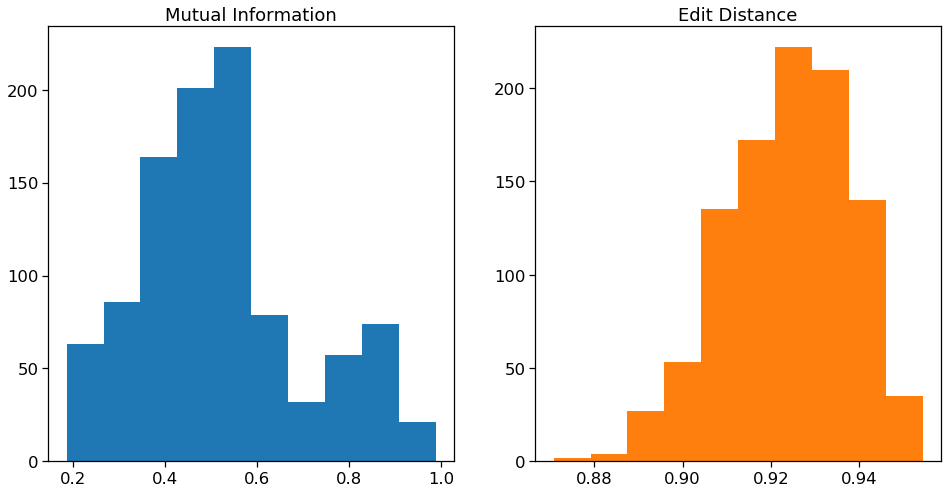

In [96]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.hist(metrics.iloc[:, 1])
plt.title("Mutual Information")
plt.subplot(1,2,2)
plt.hist(metrics.iloc[:, 2], color = "C1")
plt.title("Edit Distance")
pass

In [335]:
# info_results = metrics5_DC.iloc[:, [1,2]].mean(axis = 0)
# info_results.index = ['Mutual Information', "Edit Distance"]
# info_results
dc5 = np.array(metrics5_DC.iloc[:, [1,2]].mean(axis = 0))[:, None]
dc10 = np.array(metrics10_DC.iloc[:, [1,2]].mean(axis = 0))[:, None]
fo5 = np.array(metrics5_FO.iloc[:, [1,2]].mean(axis = 0))[:, None]
fo10 = np.array(metrics10_FO.iloc[:, [1,2]].mean(axis = 0))[:, None]
info_results = pd.DataFrame(np.hstack((fo5, fo10, dc5, dc10)))
info_results.index = ['Mutual Information', "Edit Distance"]
info_results.columns = ["HMM-5", "HMM-10", "Dilated-5", "Dilated-10"]
info_results

,HMM-5,HMM-10,Dilated-5,Dilated-10
Mutual Information,0.264359,0.261766,0.693221,0.708705
Edit Distance,0.915485,0.915351,0.963872,0.963572


In [336]:
np.array(metrics10_DC.iloc[:, [1,2]].mean(axis = 0))

array([0.70870503, 0.96357165])

## KL- Divergence

Calculate KL-Divergence between distribution of metrics on original pieces and on all generated pieces

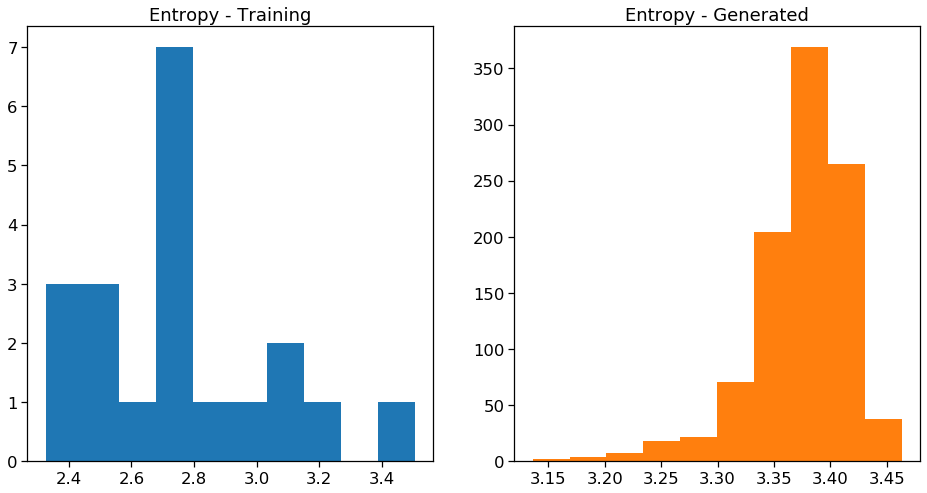

In [100]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.hist(orig.iloc[:, 0])
plt.title("Entropy - Training")
plt.subplot(1,2,2)
plt.hist(metrics.iloc[:, 0], color = "C1")
plt.title("Entropy - Generated")
pass

In [337]:
## Calculate KL divergence between original training pieces metrics and generated pieces metrics
## One metric at a time
## num_bins is number of bins to have in histogram for distribution comparison
def KL_divergence(orig, generated, num_bins):
    h = np.max([np.max(orig), np.max(generated)])
    l = np.min([np.min(orig), np.min(generated)])
    h = np.ceil(h)
    l = np.floor(l)
    ## Need to create a histogram so can compare distributions
    counts_orig, bins_orig = np.histogram(orig, bins = np.arange(l, h, step = (h-l)/num_bins))
    counts_gen, bins_ogen = np.histogram(generated, bins = np.arange(l, h, step = (h-l)/num_bins))
    
    counts_orig = counts_orig.astype("float32")
    counts_gen = counts_gen.astype("float32")
    ## Can't have 0s in KL divergence
    if np.any(counts_orig == 0):
        inds = np.where(counts_orig == 0)[0]
        counts_orig[inds] = 0.001
    
    if np.any(counts_gen == 0):
        inds = np.where(counts_gen == 0)[0]
        counts_gen[inds] = 0.001
    
    
    ## Calculate KL divergence
    KL = scipy.stats.entropy(counts_orig, counts_gen)
    return(KL)

In [339]:
KL_divergence(orig.iloc[:, 0], metrics5_DC.iloc[:, 0], 100)

10.987824

### Calculate for all Metrics

In [343]:
KLresults_DC5 = np.zeros(metrics5_DC.shape[1])
KLresults_DC5[0] = KL_divergence(orig.iloc[:, 0], metrics5_DC.iloc[:, 0], 100)
for i in range(3,len(KLresults_DC5)):
    if i == 33 or i == 74:
        KLresults_DC5[i] = 0 ## ACF/PACF for lag 0 = 1
    else:
        KLresults_DC5[i] = KL_divergence(orig.iloc[:, i], metrics5_DC.iloc[:, i], 100)
        
## Dilated 10

KLresults_DC10 = np.zeros(metrics10_DC.shape[1])
KLresults_DC10[0] = KL_divergence(orig.iloc[:, 0], metrics10_DC.iloc[:, 0], 100)
for i in range(3,len(KLresults_DC10)):
    if i == 33 or i == 74:
        KLresults_DC10[i] = 0 ## ACF/PACF for lag 0 = 1
    else:
        KLresults_DC10[i] = KL_divergence(orig.iloc[:, i], metrics10_DC.iloc[:, i], 100)

In [344]:
KLresults_FO5 = np.zeros(metrics5_FO.shape[1])
KLresults_FO5[0] = KL_divergence(orig.iloc[:, 0], metrics5_FO.iloc[:, 0], 100)
for i in range(3,len(KLresults_FO5)):
    if i == 33 or i == 74:
        KLresults_FO5[i] = 0 ## ACF/PACF for lag 0 = 1
    else:
        KLresults_FO5[i] = KL_divergence(orig.iloc[:, i], metrics5_FO.iloc[:, i], 100)
        
## First Order 10

KLresults_FO10 = np.zeros(metrics10_FO.shape[1])
KLresults_FO10[0] = KL_divergence(orig.iloc[:, 0], metrics10_FO.iloc[:, 0], 100)
for i in range(3,len(KLresults_FO10)):
    if i == 33 or i == 74:
        KLresults_FO10[i] = 0 ## ACF/PACF for lag 0 = 1
    else:
        KLresults_FO10[i] = KL_divergence(orig.iloc[:, i], metrics10_FO.iloc[:, i], 100)

In [349]:
KLresults = np.vstack((KLresults_FO5, KLresults_FO10, KLresults_DC5, KLresults_DC10))
KLresults.shape

(4, 115)

In [360]:
## Average over relevant metrics
ent = KLresults[:, 0][:, None]
hints = np.mean(KLresults[:, 3:14], axis = 1)[:, None]
mints = np.mean(KLresults[:, 15:26], axis = 1)[:, None]
perc = np.mean(KLresults[:, 27:32], axis = 1)[:, None]
acf = np.mean(KLresults[:, 33:74], axis = 1)[:, None]
pacf = np.mean(KLresults[:, 74:], axis = 1)[:, None]

In [361]:
results = np.hstack((ent, hints, mints, perc, acf, pacf))
results.shape


(4, 6)

In [363]:
results_tab = pd.DataFrame(results, columns = ['entropy', 'h_ints', 'm_ints',
                                           'percent', 'acf', 'pacf'])

results_tab.index = ["HMM-5", "HMM-10", "Dilated-5", "Dilated-10"]
results_tab

,entropy,h_ints,m_ints,percent,acf,pacf
HMM-5,11.081898,3.088239,3.888511,7.753126,5.168823,2.601845
HMM-10,11.081490,2.942701,3.962891,8.079947,5.024643,2.468823
Dilated-5,10.987824,4.367955,7.574507,9.604578,5.133139,2.550771
Dilated-10,10.988585,4.456194,7.546614,9.806183,4.977989,2.426926


### ACF/PACF

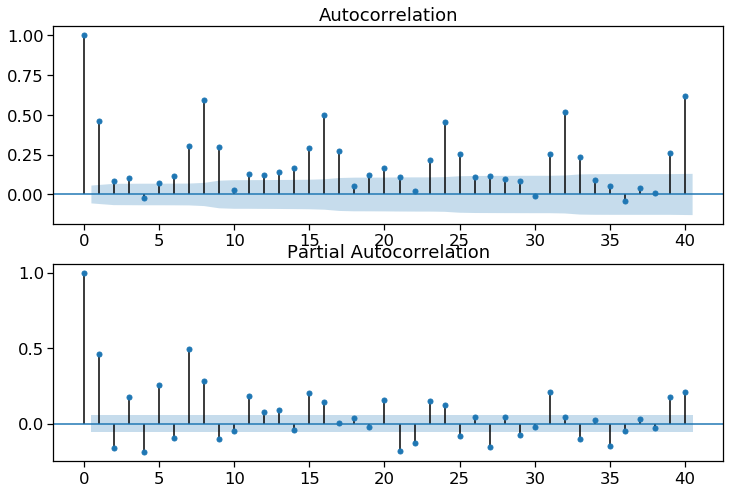

In [367]:
## Original Piece
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mat_pieces[1,:Tlist[1]], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mat_pieces[1,:Tlist[1]], lags=40, ax=ax2)

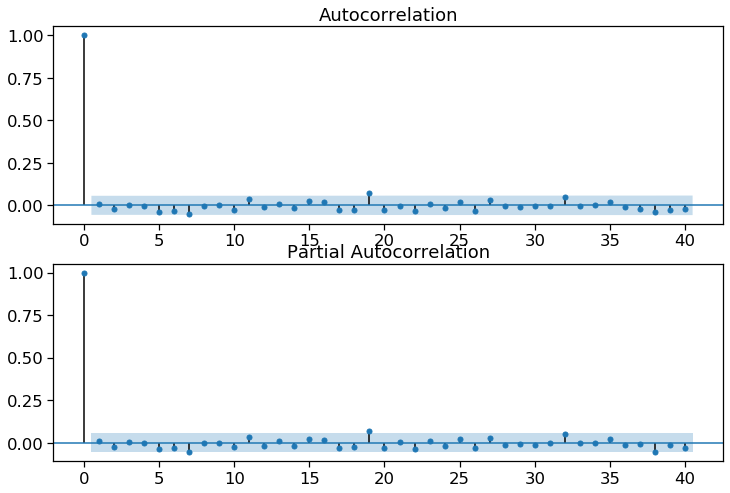

In [370]:
## First Order
pi = np.load("Label-Switch-Parameters/HMM-5-pi.npy")
b = np.load("Label-Switch-Parameters/HMM-5-b.npy")
A = np.load("Label-Switch-Parameters/HMM-5-A.npy")

newNotes, z  = generate(Tlist[1],pi,b,A)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes, lags=40, ax=ax2)

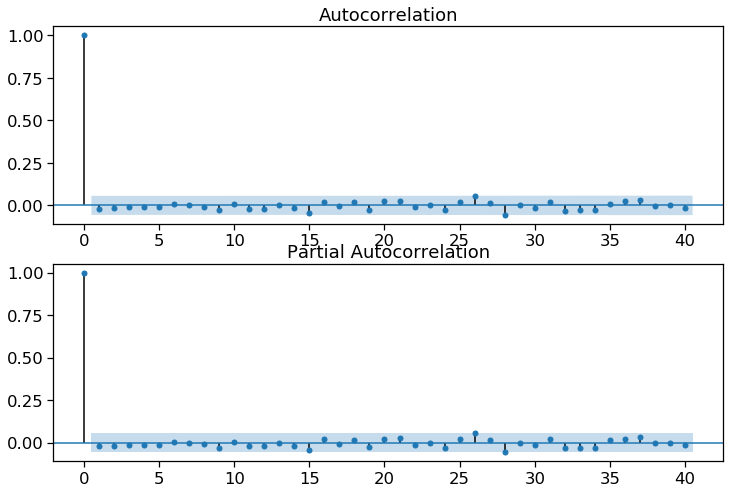

In [368]:
## Dilated Convolutions
pi = np.load("Label-Switch-Parameters/DC-5-pi.npy")
b0 = np.load("Label-Switch-Parameters/DC-5-b0.npy")
b = np.load("Label-Switch-Parameters/DC-5-b.npy")
A = np.load("Label-Switch-Parameters/DC-5-A.npy")

newNotes, z  = generate_dilated(Tlist[1],pi,b0,b,A)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes, lags=40, ax=ax2)

## Histograms

In [180]:
plt.style.use('seaborn')

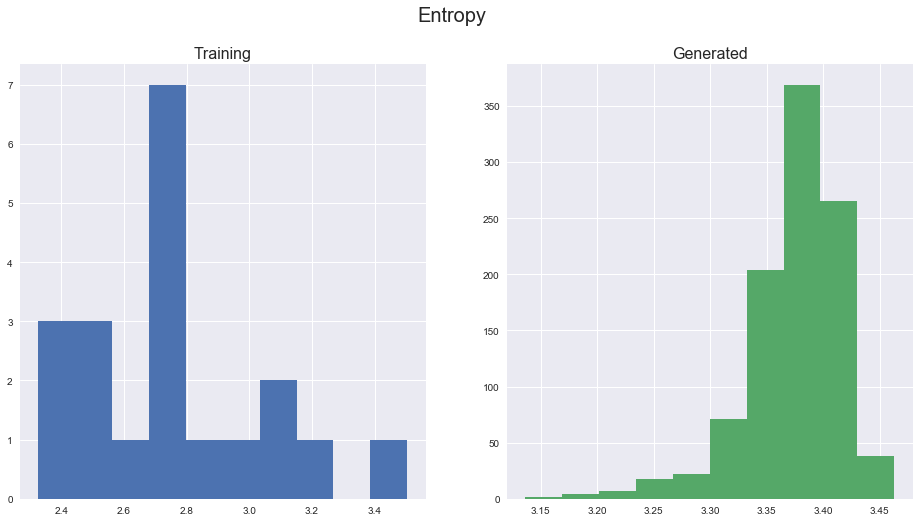

In [186]:
plt.figure(figsize = (16,8))
plt.rcParams.update({'font.size': 22})
plt.subplot(1,2,1)
plt.hist(orig.iloc[:, 0])
plt.suptitle("Entropy", fontsize=20)
plt.title("Training", fontsize=16)
plt.subplot(1,2,2)
plt.hist(metrics.iloc[:, 0], color = "C1")
plt.title("Generated", fontsize = 16)
pass

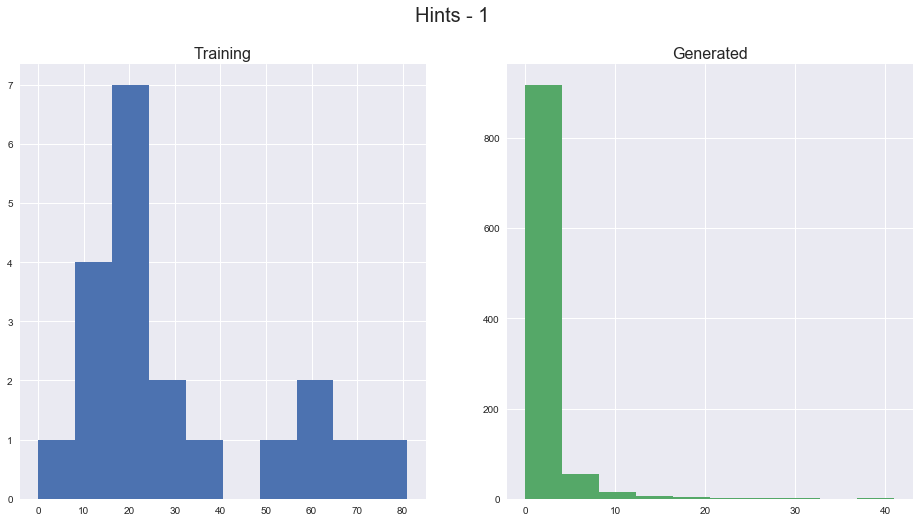

In [187]:
plt.figure(figsize = (16,8))
plt.rcParams.update({'font.size': 22})
plt.subplot(1,2,1)
plt.hist(orig.iloc[:, 3])
plt.suptitle("Hints - 1", fontsize=20)
plt.title("Training", fontsize=16)
plt.subplot(1,2,2)
plt.hist(metrics.iloc[:, 3], color = "C1")
plt.title("Generated", fontsize = 16)
pass